In [1]:
import numpy as np
from nfwfitter import nfwutils # from the https://github.com/deapplegate/clmassmod package
import wget

In [2]:
cluster = 39
link = "http://cita.utoronto.ca/~nbatta/ACT_POL/Clusters_4_Lensing/z_0_5/1e14_1.5e14/"
#wget.download(link + "DM/GEN_Cluster_MassDM_%iL165.256.FBN2_snap47_comovFINE.d" % cluster)
#wget.download(link + "Gas/GEN_Cluster_MassGas_%iL165.256.FBN2_snap47_comovFINE.d" % cluster)
#wget.download(link + "Star/GEN_Cluster_MassStar_%iL165.256.FBN2_snap47_comovFINE.d" % cluster)

In [3]:
def getmap(f, pix):
    fd = open(f, 'rb')
    temp = np.fromfile(file=fd, dtype=np.float32)
    fd.close()
    return np.reshape(temp,(pix,pix))

In [4]:
PIX = 2048
zcluster = 0.5

In [5]:
star_mass = getmap("GEN_Cluster_MassStar_%iL165.256.FBN2_snap47_comovFINE.d" % cluster, PIX)
gas_mass = getmap("GEN_Cluster_MassGas_%iL165.256.FBN2_snap47_comovFINE.d" % cluster, PIX)
dm_mass = getmap("GEN_Cluster_MassDM_%iL165.256.FBN2_snap47_comovFINE.d" % cluster, PIX)

In [6]:
total_mass = star_mass + gas_mass + dm_mass

In [7]:
curcosmo = nfwutils.global_cosmology
Dl = curcosmo.angulardist(zcluster)
beta_inf = curcosmo.beta([1e6], zcluster)
sigma_crit = (curcosmo.v_c**2/(4*np.pi*curcosmo.G))/(Dl*beta_inf)  #units are M_dot / Mpc^2
convert_units = 1./(curcosmo.h*1e6)
converted_sigma_crit = sigma_crit * convert_units

In [8]:
kappa = total_mass / converted_sigma_crit

In [9]:
%matplotlib inline
import pylab

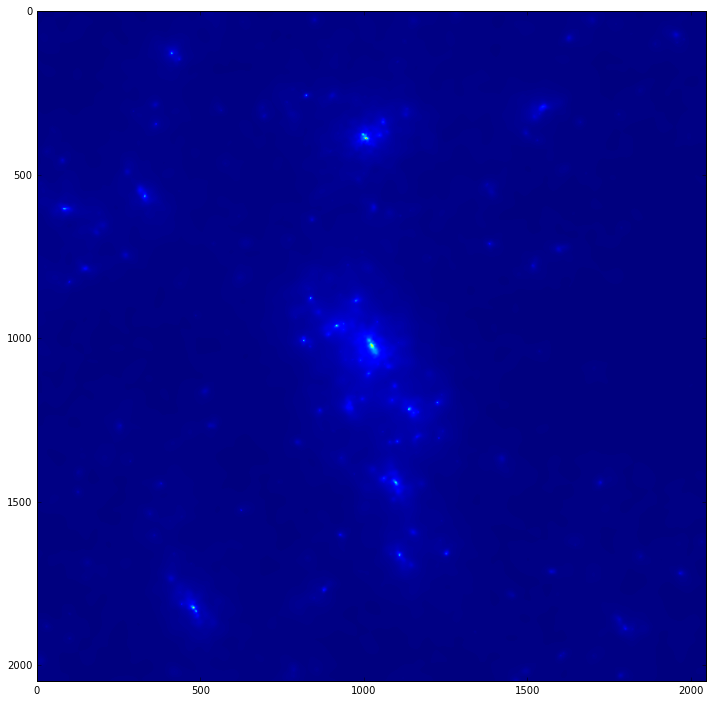

In [10]:
fig = pylab.figure(figsize=(12, 12))
pylab.imshow(kappa)

In [11]:
# put the 2D convergence map into fourier space
kappaf = np.fft.fft2(kappa)

# then get the corresponding frequencies
pix = 0.00390624 # Mpc/h
freqx = np.fft.fftfreq(kappaf.shape[0], d=pix)
freqy = np.fft.fftfreq(kappaf.shape[1], d=pix)
freqy, freqy = np.meshgrid(freqx, freqy)

In [12]:
# now the shears
gamma1f = np.zeros((kappaf.shape[0], kappaf.shape[1]), dtype=complex)
gamma2f = np.zeros((kappaf.shape[0], kappaf.shape[1]), dtype=complex)

gamma1f = kappaf * (freqx**2 - freqy**2) / (freqx**2 + freqy**2)
gamma2f = 2. * kappaf*(freqx * freqy) / (freqx**2 + freqy**2)

/home/chotard/Work/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide
/home/chotard/Work/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


In [13]:
# replace bad elements in case there were some nans generated in the transform
gamma1f = np.nan_to_num(gamma1f)
gamma2f = np.nan_to_num(gamma2f)

In [14]:
# convert back to real space
gamma1 = np.fft.ifft2(gamma1f).real
gamma2 = np.fft.ifft2(gamma2f).real

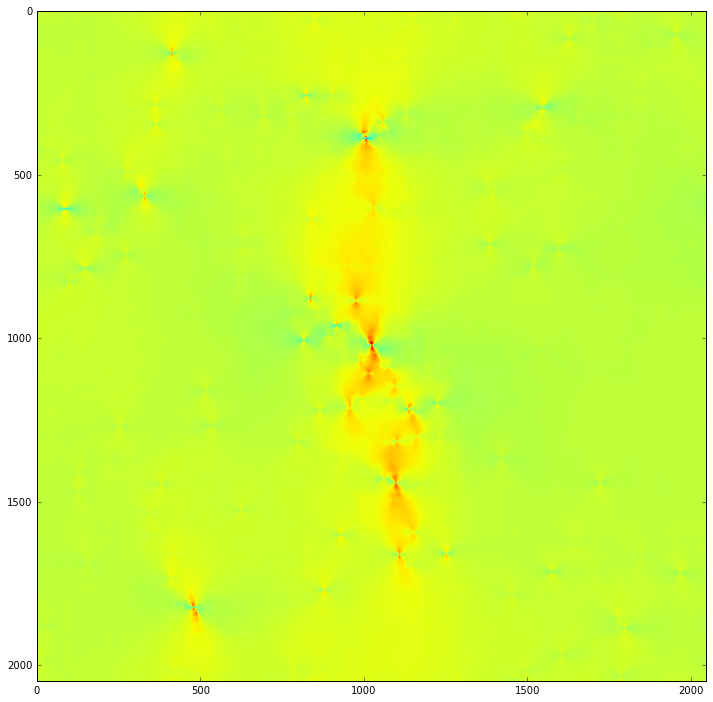

In [15]:
fig = pylab.figure(figsize=(12, 12))
pylab.imshow(gamma1)

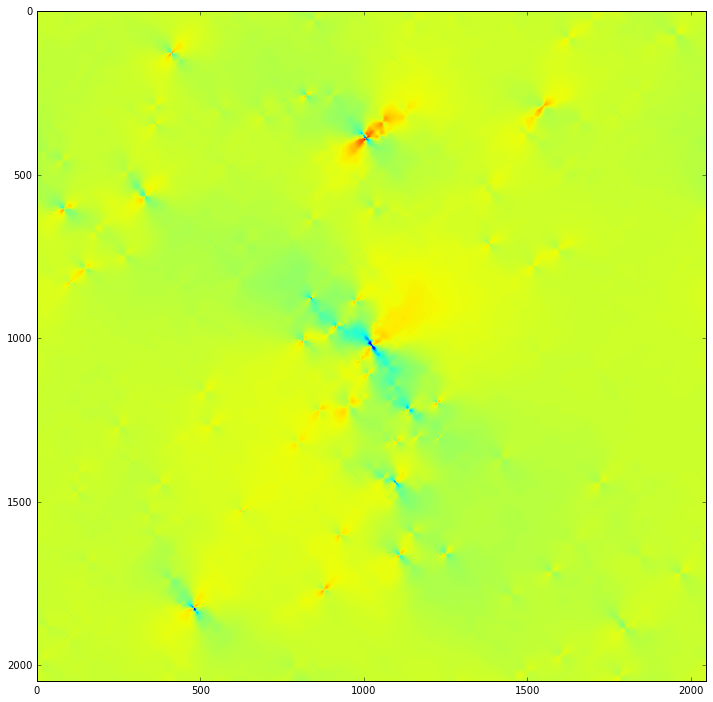

In [16]:
fig = pylab.figure(figsize=(12, 12))
pylab.imshow(gamma2)

In [17]:
def rebin2(inArray, shape):
    #rebin of 2D array into shape
    sh = shape[0],inArray.shape[0]//shape[0],shape[1],inArray.shape[1]//shape[1]
    return inArray.reshape(sh).mean(-1).mean(1)

In [18]:
# rebinning
gamma1 = rebin2(gamma1,[64,64])
gamma2 = rebin2(gamma2,[64,64])

In [20]:
# gamma1 and gamma2 are not orthogonal. Switch to cartesian before plotting in the quiver
gamma_mag = (gamma1**2 + gamma2**2)**0.5
gamma_phi = 0.5 * np.arctan2(gamma2, gamma1)

gammax = gamma_mag * np.cos(gamma_phi)
gammay = gamma_mag * np.sin(gamma_phi)

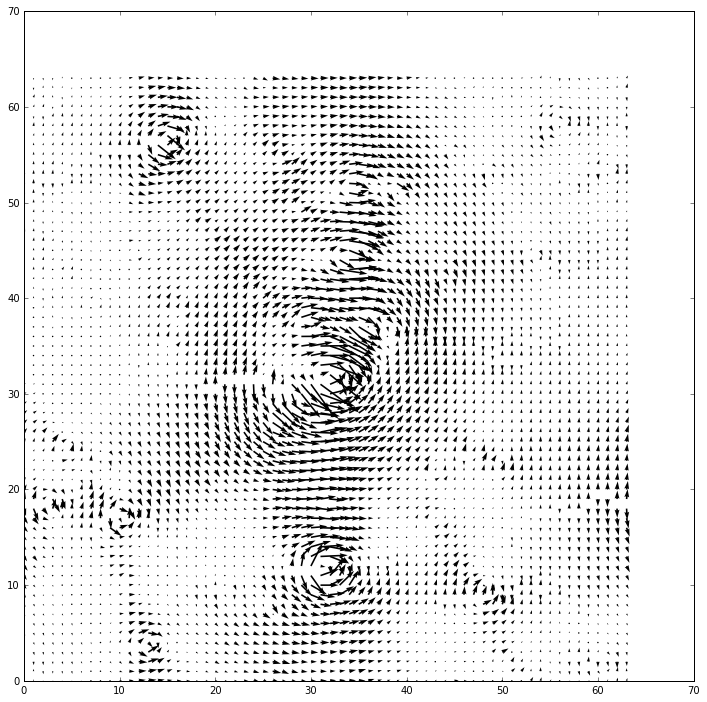

In [21]:
fig = pylab.figure(figsize=(12, 12))
pylab.quiver(gammax, gammay)